<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Gaussian_Mixture_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
import torch

In [3]:
# install sentence-trasnformers
%%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('whaleloops/phrase-bert')

In [ ]:
# download the ENGLISH data

shift_class_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_classified_df.csv', encoding='ISO-8859-1')

# remove NaN rows
shift_class_df['Bleached sense'] = shift_class_df['Bleached sense'].fillna('NaN')
shift_class_df = shift_class_df[shift_class_df['Bleached sense']!='NaN']

# remove completely duplicated rows
shift_class_df = shift_class_df[~shift_class_df.duplicated()]

# these seem a little outside of our area of study 
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'grammaticalization']
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'synaesthesia']

allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
shift_class_df = shift_class_df[shift_class_df['Type of change'].isin(allowed_types)]

shift_class_df = shift_class_df.reset_index()

In [ ]:
# get rid of punctuation in the senses for the English data

def cleanString(s):
  s = s.lower()
  s = s.replace("'", "")
  s = s.replace(",", "")
  s = s.replace(";", "")
  s = s.lower()
  return s

shift_class_df['meaning1'] = shift_class_df['meaning1'].apply(cleanString)
shift_class_df['meaning2'] = shift_class_df['meaning2'].apply(cleanString)

In [4]:
# download the DatSemShift data (don't run this cell if you want to work with English)

sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_dat_sem_shift.csv')

sem_shift_df['meaning1'] = sem_shift_df['meaning1_clean']
sem_shift_df['meaning2'] = sem_shift_df['meaning2_clean']

sem_shift_df = sem_shift_df.drop([697, 1521])

shift_class_df = sem_shift_df[sem_shift_df['realizations'] > 1]

shift_class_df = shift_class_df.reset_index()

In [5]:
# create a dictionary for the embeddings
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

for i in range(len(shift_class_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = shift_class_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [6]:
# create dataframe with a pair of embeddings for each shift

all_vars_df = pd.DataFrame()
all_vars_df['meaning1'] = shift_class_df['meaning1']
all_vars_df['meaning2'] = shift_class_df['meaning2']

# #if working with the English database, these are helpful
# all_vars_df['word'] = shift_class_df['Word']
# all_vars_df['type'] = shift_class_df['Type of change']

vec_df = pd.DataFrame.from_dict(vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [vec_meaning_df, vec_df])
vec_meaning_df = vec_meaning_df.drop(['Word_x', 'Word_y'], axis=1)

In [7]:
# create dataframe with one difference embedding for each shift

vec_diff_df = pd.DataFrame()

for i in range(len(model.encode('yikes'))):
  vec_diff_df[i] = vec_meaning_df[str(i) + "_y"] - vec_meaning_df[str(i) + "_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [8]:
# create dataframe with all shifts and difference vectors 

source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [all_vars_df, vec_diff_df])

In [28]:
# perform pca, just so the gaussian mixture will perform a little better
# x = source_shift_df.drop(['word', 'meaning1', 'meaning2', 'type'], axis=1).values # if working with English database
x = source_shift_df.drop(['meaning1', 'meaning2'], axis=1).values
scaler = StandardScaler()
scaler.fit(x)
x_scale = scaler.transform(x)

# do PCA
pca = PCA(n_components=50)
pca.fit(x_scale)
components = pca.transform(x_scale)
components_df = pd.DataFrame(data = components)#.rename(columns={0:'PC_1' , 1:'PC_2', 2:"PC_3", 3:'PC_4'})

# merge back into word data
df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, components_df])

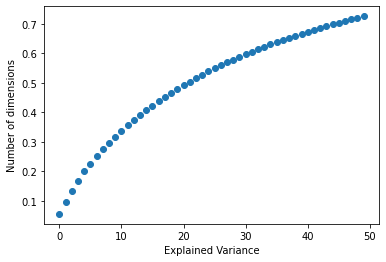

In [10]:
# check explained variance

plt.xlabel("Explained Variance")
plt.ylabel("Number of dimensions")
plt.scatter(range(50), np.cumsum(pca.explained_variance_ratio_))

## GMM

### 2d / scatterplot

In [15]:
# just try fitting on the first two components

n_components = 5
estimator = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=20, random_state=0) # other covariance is "spherical", "diag", "tied"
estimator.fit(df[[0, 1]])

GaussianMixture(max_iter=20, n_components=5, random_state=0)

In [17]:
# function for making ellipses. can't be more colors than clusters, or it'll throw an error

el_colors = ['red', 'orange', 'yellow', 'green', 'blue']

def make_ellipses(gmm, ax):
    for n, color in enumerate(el_colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

<Figure size 1440x1440 with 0 Axes>

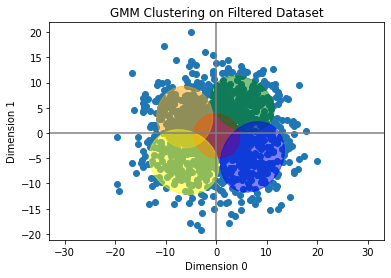

In [18]:
plt.figure(figsize=(20, 20))

fig, ax = plt.subplots()
# colors 
# allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
# colors = {'metaphor':'maroon', 'metonymy': 'red', 'analogy': 'pink','antonymy': 'pink','narrowing':'blue', 'pejoration':'green', 'broadening':'purple', 'amelioration': 'orange', 'broadening, metaphor': 'red', 'pejoration, homophony':'green'}
# markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
#ax.legend(markers, colors.keys(), numpoints=1)

ax.axhline(y=0, color='grey')
ax.axvline(x=0, color='grey')

ax.scatter(df[0], df[1]) #, c=df_filter.colors)
#ax.scatter(estimator.means_[:,0], estimator.means_[:,1], c='black')

ax.title.set_text("GMM Clustering on Filtered Dataset")
ax.set_xlabel("Dimension 0")
ax.set_ylabel("Dimension 1")

# def getLabel(row):
#   return (row['meaning1'] + " → " + row['meaning2'], (row[0], row[1]))
#   #return (row['word'], (row['0_y'], row['1_y']))

# labels = []

# labels.append(getLabel(df_filter.iloc[54])) #throat
# labels.append(getLabel(df_filter.iloc[47])) #shoulder
# labels.append(getLabel(df_filter.iloc[19])) #foot/leg
# labels.append(getLabel(df_filter.iloc[44])) #rooster
# #labels.append(getLabel(df_filter.iloc[11])) #donkey
# labels.append(getLabel(df_filter.iloc[5])) #cattle
# labels.append(getLabel(df_filter.iloc[4])) #bull

# for label in labels:
#   ax.annotate(label[0], label[1])

# ax.figure.set_size_inches(8, 5)

make_ellipses(estimator, ax)

### 50d

In [29]:
# group the shifts

n_dimensions = 50
n_components = 30
estimator = GaussianMixture(n_components=n_components, covariance_type='spherical', init_params='kmeans', max_iter=20) # other covariance is "spherical", "diag", "tied"
estimator.fit(df[range(n_dimensions)])

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


GaussianMixture(covariance_type='spherical', max_iter=20, n_components=30)

In [30]:
# add information to each of the shifts about how they relate to the clusters
# a) their distance from each of the clusters 'dist_n'
# b) cosine similarity to the means of each of the clusters 'sim_n'
# c) probablility they're in each cluster 'prob_n'
# d) the cluster that they're most likely to be in 'label' 

def toTensor(arr):
  return torch.tensor(arr, dtype = torch.float32) #Function to easily convert arrays to tensors

# distance + cosine similarity from the means
for n in range(len(estimator.means_)):
  df['dist_' + str(n)] = np.linalg.norm(df[range(n_dimensions)] - estimator.means_[n], axis=1)
  df['sim_' + str(n)] = util.cos_sim(np.asarray(df[range(n_dimensions)]), toTensor(estimator.means_[n]))

# gmm gives a probability estimator, but it's kind of crap, and often gives 1.0 and 0.0
prob_df = pd.DataFrame(estimator.predict_proba(np.asarray(df[range(n_dimensions)])))
prob_df.columns = ['prob_'+str(i) for i in range(len(estimator.means_))]

# they also label points by probability -- not really what we want, but interesting
label_df = pd.DataFrame(estimator.predict(np.asarray(df[range(n_dimensions)])))
label_df = label_df.rename(columns={0:'label'})

clusters_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [df, prob_df])
clusters_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [clusters_df, label_df])

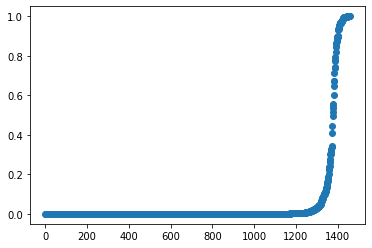

In [31]:
# also, the plot of distances from the means is generally an s-shape (english + datsemshift)

n=5
plt.scatter(range(len(clusters_df)), clusters_df.sort_values(by=('prob_' + str(n)))['prob_' + str(n)])


In [32]:
# sort by likelihood of being in that group

n=2
clusters_df[['meaning1', 'meaning2', ('prob_' + str(n)), 'label', ('dist_' + str(n)), ('sim_' + str(n))]].sort_values(by=('sim_' + str(n)), ascending=False).head(20)

,meaning1,meaning2,prob_2,label,dist_2,sim_2
755,shoulder,mountain slope,1.000000,2,13.636464,0.894540
308,forehead,mountain slope,1.000000,2,14.805964,0.885295
601,neck,mountain ridge or edge,1.000000,2,14.175988,0.870637
600,neck,mountain pass,1.000000,2,13.927023,0.866753
127,chest body part,mountain slope,1.000000,2,17.502673,0.864839
125,cheek,mountain slope,1.000000,2,16.110613,0.843413
865,throat,ravine,1.000000,2,12.924621,0.841888
261,face,mountain slope,1.000000,2,20.055004,0.809235
30,back body part,mountain ridge or edge,1.000000,2,20.068702,0.794871
573,mouth,mouth of a river,0.999996,2,17.034508,0.768341


## labelling clusters 

In [23]:
# get list of adjectives from frequency database because why not

freqDF = pd.read_csv('/content/drive/MyDrive/ColabFiles/COCA_freqs.csv', encoding='ISO-8859-1') # w1, coca_spok
adjectives = list(freqDF[(freqDF['c1']=='jj') & (freqDF['BNC']>500)]['w1'])

In [24]:
# embed in the model

adj_embeddings = model.encode(adjectives, convert_to_tensor=True)

In [25]:
# find closest adjectives to the estimator.mean

top_k = 5

def toTensor(arr):
  return torch.tensor(arr, dtype = torch.float32) #Function to easily convert arrays to tensors

source_words = []
target_words = []

for i in range(len(estimator.means_)):
    # target
    targets = []

    query_embedding = toTensor(estimator.means_[i])

    cos_scores = util.cos_sim(query_embedding, toTensor(pca.transform(adj_embeddings)))[0]
    top_results = torch.topk(cos_scores, k=top_k)

    for score, idx in zip(top_results[0], top_results[1]):
      targets.append(adjectives[idx])

    # source
    sources = []

    query_embedding = -toTensor(estimator.means_[i])

    cos_scores = util.cos_sim(query_embedding, toTensor(pca.transform(adj_embeddings)))[0]
    top_results = torch.topk(cos_scores, k=top_k)

    for score, idx in zip(top_results[0], top_results[1]):
      sources.append(adjectives[idx])
    
    source_words.append(sources)
    target_words.append(targets)

In [35]:
# use the label given by the model

n=4
print(source_words[n])
print(target_words[n])
clusters_df[['meaning1', 'meaning2', ('prob_' + str(n)), ('dist_' + str(n))]][clusters_df['label']==n]

['colonic', 'colonial', 'atomic', 'roman', 'territorial']
['late', 'planned', 'sorry', 'overnight', 'weekly']


,meaning1,meaning2,prob_4,dist_4
13,alive,active,0.608482,21.239735
17,amber,electricity,0.658090,26.864376
78,board or plank,shield,0.594394,23.649482
90,bow weapon,fire arms,0.935288,18.006838
92,bowels or intestine,location of emotions,0.996387,21.562377
108,button on a dress,push button,0.999762,18.386336
112,candle,spark plug,0.995589,19.310693
113,carriage,automobile,0.962297,15.349115
123,chaff,useless thing,0.656807,19.731576
131,chopped billet,base for beheading,0.998797,19.451069


## how many clusters? 

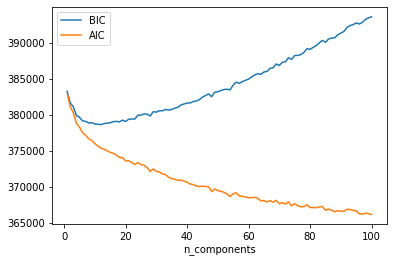

In [ ]:
n_components = np.arange(1, 101)
models = [GaussianMixture(n, covariance_type='spherical', random_state=0).fit(df[range(50)]) for n in n_components]
plt.plot(n_components, [m.bic(df[range(50)]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df[range(50)]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

i guess the optimal number is like 17 for the English dataset

for the semantic shift dataset, looks like GMM is just ... not the way to go.